In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from os.path import isfile, join
from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoFoldersDataset, MontevideoFoldersDataset_w_time, PatchesFoldersDataset_w_geodata

#Deep Learning
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

import random
from src.dl_models.unet import UNet, UNet2
from src.lib.latex_options import Colors, Linestyles


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
FRAME_OUT = 30
OUTPUT_LAST = False
PREDICT_DIFF = True
OUTPUT_ACTIVATION = 'tanh' 
REGION = 'R3'
dataset='region3'

MODEL_NAME = utils.get_model_name(predict_horizon='60min', architecture='UNET2', predict_diff=PREDICT_DIFF)
MODEL_60_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/' + REGION + '/60min/' + MODEL_NAME
MODEL_NAME = utils.get_model_name(predict_horizon='120min', architecture='UNET2', predict_diff=PREDICT_DIFF)
MODEL_120_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/' + REGION + '/120min/' + MODEL_NAME
MODEL_NAME = utils.get_model_name(predict_horizon='180min', architecture='UNET2', predict_diff=PREDICT_DIFF)
MODEL_180_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/' + REGION + '/180min/' + MODEL_NAME
MODEL_NAME = utils.get_model_name(predict_horizon='240min', architecture='UNET2', predict_diff=PREDICT_DIFF)
MODEL_240_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/' + REGION + '/240min/' + MODEL_NAME
MODEL_NAME = utils.get_model_name(predict_horizon='300min', architecture='UNET2', predict_diff=PREDICT_DIFF)
MODEL_300_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/' + REGION + '/300min/' + MODEL_NAME 

model_60 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_60.load_state_dict(torch.load(MODEL_60_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_60.eval()

model_120 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_120.load_state_dict(torch.load(MODEL_120_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_120.eval()

model_180 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_180.load_state_dict(torch.load(MODEL_180_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_180.eval()

model_240 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_240.load_state_dict(torch.load(MODEL_240_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_240.eval()

model_300 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_300.load_state_dict(torch.load(MODEL_300_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_300.eval()

CMV = model.Cmv2()

print('Done.')

Done.


In [5]:
CSV_PATH = '/clusteruy/home03/DeepCloud/deepCloud/data/region3/test_cosangs_region3.csv'

val_mvd = MontevideoFoldersDataset_w_time(
    path='/clusteruy/home03/DeepCloud/deepCloud/data/' + dataset + '/test/',
    in_channel=3,
    out_channel=FRAME_OUT,
    min_time_diff=5,
    max_time_diff=15,
    csv_path=CSV_PATH,
    transform=preprocessing.normalize_pixels(mean0 = False),
    output_last=OUTPUT_LAST
)

val_loader = DataLoader(val_mvd, batch_size=1, shuffle=True)
iterator = iter(val_loader)

In [26]:
def show_seq_and_pred(sequence_array, time_list, prediction_t, fig_name=None, grid=True, day=None, model=None, savefig=False):
    """ Shows the images passed in a grid
    Args:
        sequence_array (array)
    """
    nbof_frames = sequence_array.shape[0]
    if np.max(sequence_array[0]) > 1.1:
        vmax = 100
    else:
        vmax = 1
    alpha = 0.2
    # plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    fontsize = 30 # 22 generates the font more like the latex text

    # plt.figure(figsize=(25, 5))
    fix = 2 if nbof_frames == 5 else 3
    fig, ax = plt.subplots(1, nbof_frames, figsize=(6 * nbof_frames - fix, 5)) # H,W of the whole fig

    
    for i in range(nbof_frames):
        if i < nbof_frames - 2:
            ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            input_nbr = i - (nbof_frames - 3)
            ax[i].set_title(f'{time_list[i]}', fontsize=fontsize)
            ax[i].set_xticklabels([])
            ax[i].set_yticklabels([])
            ax[i].tick_params(length=0)
            ax[i].grid(grid, alpha=alpha)


        if i == nbof_frames - 2:
            im = ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            #cbar = plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
            ax[i].set_title(f'(GT) {time_list[-1]}', fontsize=fontsize)
            ax[i].set_xticklabels([])
            ax[i].set_yticklabels([])
            ax[i].tick_params(length=0)
            ax[i].grid(grid, alpha=alpha)

        if i == nbof_frames - 1:
            im = ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            #cbar = plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
            ax[i].set_title(f'(Pred) {time_list[-1]}', fontsize=fontsize)
            ax[i].set_xticklabels([])
            ax[i].set_yticklabels([])
            ax[i].tick_params(length=0)
            ax[i].grid(grid, alpha=alpha)

        if nbof_frames == 6:
            line = plt.Line2D((.666, .666),(.03, 1), linewidth=3, color='gray', alpha=.5)
        elif nbof_frames == 5:
            line = plt.Line2D((.600, .600),(.03, 1), linewidth=3, color='gray', alpha=.5)
        else:
            line = plt.Line2D((.52, .52),(.1, 1), linewidth=3, color='gray', alpha=.5)
        fig.add_artist(line)

    if savefig:
        fig.tight_layout()
        time = time_list[-1].replace(':', '')
        # fig.savefig(f'reports/doc_images/{model}.png')
        fig.savefig(f'reports/doc_images/{model}_day{str(day)}_time{time}.png')
        
    plt.show()

    
def input_seq(input_list, vmax=None, colormap='viridis', grid=True, alpha=0.2,  output=False, fig_name=None, save_fig=False):

    if len(input_list) != 3:
        raise ValueError('Must input 3 images')
    fontsize = 18
    fig, ax = plt.subplots(1, 3, figsize=(13, 4))
    plt.subplots_adjust(wspace=0.05)
    for i in range(len(input_list)):
        if vmax:
            ax[i].imshow(input_list[i], vmin=0, vmax=vmax, cmap=colormap)
        else:
            ax[i].imshow(input_list[i], cmap=colormap)
        if output:
            if i == 0:
                ax[i].set_title(f'Ground Truth', fontsize=fontsize)
            elif i == 1:
                ax[i].set_title(f'U-Net Diff prediction', fontsize=fontsize)
            elif i == 2:
                ax[i].set_title(f'CMV prediction', fontsize=fontsize)
        
        ax[i].grid(grid, alpha=alpha)
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])

        for tic in ax[i].xaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
        for tic in ax[i].yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)

    if save_fig:
        fig.tight_layout() 
        fig.savefig(fig_name)
    plt.show()

day: 333
input time: ['13:40', '13:50', '14:00']


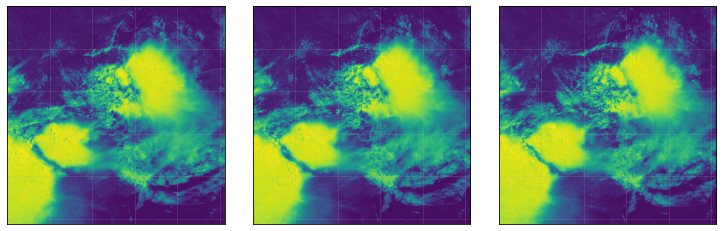

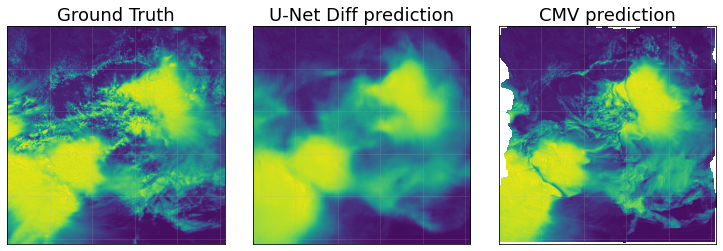

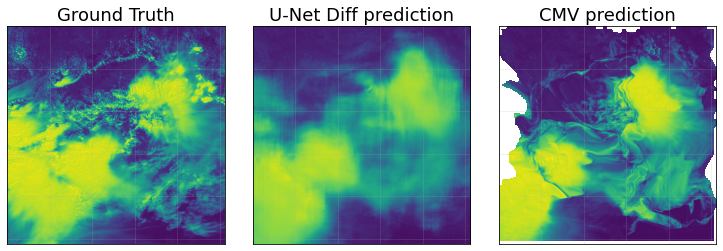

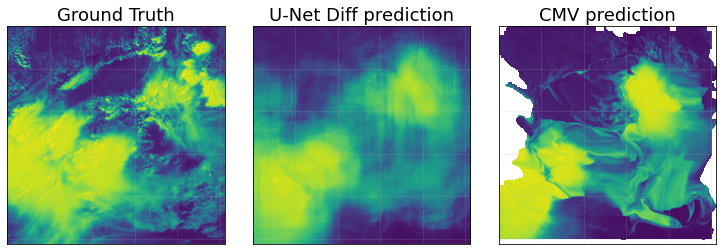

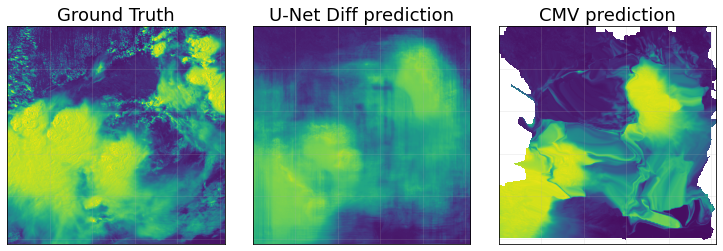

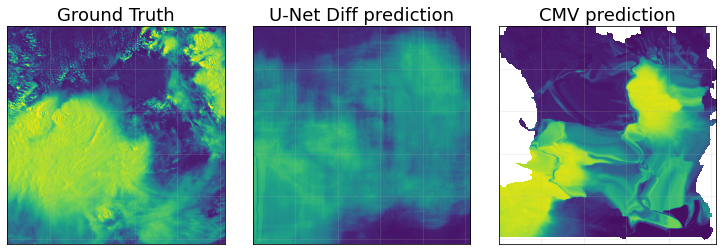

In [73]:
in_frames, out_frames, in_time, out_time = next(iterator)
in_time = in_time[0].numpy()
day = int(in_time[0,0])
# while day not in [332, 230, 17, 186, 14, 217, 143, 151, 113]:
#     in_frames, out_frames, in_time, out_time = next(iterator)
#     in_time = in_time[0].numpy()
#     day = int(in_time[0,0])
print('day:', day)


timestamp = out_time[0, 0]

with torch.no_grad():
    in_frames = in_frames.to(device=device)
    out_frames = out_frames.to(device=device)
    if PREDICT_DIFF:
        frames_pred_60 = np.clip(model_60(in_frames)[0,0].cpu().numpy() + in_frames[0,2].cpu().numpy(), 0, 1)
        frames_pred_120 = np.clip(model_120(in_frames)[0,0].cpu().numpy() + in_frames[0,2].cpu().numpy(), 0, 1)
        frames_pred_180 = np.clip(model_180(in_frames)[0,0].cpu().numpy() + in_frames[0,2].cpu().numpy(), 0, 1)
        frames_pred_240 = np.clip(model_240(in_frames)[0,0].cpu().numpy() + in_frames[0,2].cpu().numpy(), 0, 1)
        frames_pred_300 = np.clip(model_300(in_frames)[0,0].cpu().numpy() + in_frames[0,2].cpu().numpy(), 0, 1)
    in_frames = in_frames[0].cpu().numpy()
    out_frames = out_frames[0].cpu().numpy()

cmv_pred = CMV.predict(
    imgi=in_frames[1]*100,
    imgf=in_frames[2]*100,
    imgf_ts = None, 
    period=10*60, delta_t=10*60,
    predict_horizon=30
)

t_6 = str(int(timestamp[1].numpy())).zfill(2) + ':' + str(int(timestamp[2].numpy())).zfill(2)
t__2 = str(int((in_time[0][1]))).zfill(2) + ':' + str(int((in_time[0][2]))).zfill(2)
t__1 = str(int((in_time[1][1]))).zfill(2) + ':' + str(int((in_time[1][2]))).zfill(2)
t_0 = str(int((in_time[2][1]))).zfill(2) + ':' + str(int((in_time[2][2]))).zfill(2)

time_list = [t__2, t__1, t_0]
print('input time:', time_list)

input_seq([in_frames[0], in_frames[1], in_frames[2]], vmax=1, colormap='viridis', fig_name=None, save_fig=False)

# GT with PREDICTIONS

input_seq([out_frames[5], frames_pred_60, cmv_pred[5]/100], vmax=1, colormap='viridis', output=True, fig_name=None, save_fig=False)
input_seq([out_frames[11], frames_pred_120, cmv_pred[11]/100], vmax=1, colormap='viridis', output=True, fig_name=None, save_fig=False)
input_seq([out_frames[17], frames_pred_180, cmv_pred[17]/100], vmax=1, colormap='viridis', output=True, fig_name=None, save_fig=False)
input_seq([out_frames[23], frames_pred_240, cmv_pred[23]/100], vmax=1, colormap='viridis', output=True, fig_name=None, save_fig=False)
input_seq([out_frames[29], frames_pred_300, cmv_pred[29]/100], vmax=1, colormap='viridis', output=True, fig_name=None, save_fig=False)

dia | hora first input
----------------------
332 | 10:10
----------
230 | 13:00
----------
17  | 13:30
----------
186 | 13:10
----------
14  | 13:40
----------
217 | 15:20
-------------
217 | 16:30
---------
143 | 14:00
------------
151 | 13:50
----------
113 | 13:10
--------
354 | 10:50
---------
13 | 10:20
-----------

120min


100%|██████████| 3824/3824 [03:38<00:00, 17.53it/s]


[[151.  13.  50.]
 [151.  14.   0.]
 [151.  14.  10.]]


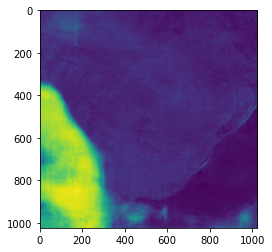

[[143.  14.   0.]
 [143.  14.  10.]
 [143.  14.  20.]]


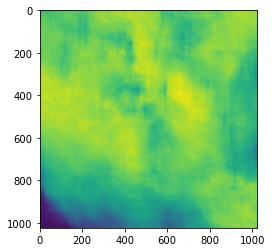

[[217.  16.  30.]
 [217.  16.  40.]
 [217.  16.  50.]]


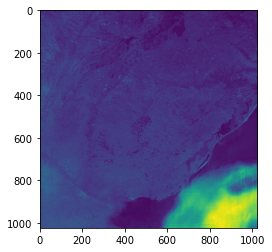

In [12]:
from tqdm import tqdm

REGION = 'R3' # [MVD, URU, R3]
dataset = 'region3'
PREDICT_DIFF = True
OUTPUT_ACTIVATION = 'tanh'
CSV_PATH = '/clusteruy/home03/DeepCloud/deepCloud/data/region3/test_cosangs_region3.csv'
PATH_DATA = '/clusteruy/home03/DeepCloud/deepCloud/data/' + dataset + '/test/'
MAE = nn.L1Loss()
MSE = nn.MSELoss()

PREDICT_HORIZON = ['120min']

for p_h in PREDICT_HORIZON:
    print(p_h)
    if p_h == '60min':
        PREDICT_T = 6
    elif p_h == '120min':
        PREDICT_T = 12
    elif p_h == '180min':
        PREDICT_T = 18
    elif p_h == '240min':
        PREDICT_T = 24
    elif p_h == '300min':
        PREDICT_T = 30

    MODEL_NAME = utils.get_model_name(predict_horizon=p_h, architecture='UNET2', predict_diff=PREDICT_DIFF)
    MODEL_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/' + REGION + '/' + p_h + '/' + MODEL_NAME

    SAVE_IMAGES_PATH = 'graphs/' + REGION + '/' + p_h + '/test/' + MODEL_PATH.split('/')[-1][:-9]  
    SAVE_VALUES_PATH = 'reports/eval_per_hour/' + REGION + '/test'

    model = UNet2(n_channels=3, n_classes=1, bilinear=True, p=0, output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)

    val_dataset = MontevideoFoldersDataset_w_time(
        path=PATH_DATA,
        in_channel=3,
        out_channel=PREDICT_T,
        min_time_diff=5,
        max_time_diff=15,
        csv_path=CSV_PATH,
        transform=preprocessing.normalize_pixels(),
        output_last=True
    )

    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu'))["model_state_dict"])
    
    
    best_MAE = 99
    best_MAE_time = 99
    best_MAE_pct = 99
    best_MAE_pct_time = 99
    best_RMSE = 99
    best_RMSE_time = 99
    

    model.eval()
    with torch.no_grad():
        for val_batch_idx, (in_frames, out_frames, in_time, out_time) in enumerate(tqdm(val_loader)):
            in_frames = in_frames.to(device=device)
            out_frames = out_frames.to(device=device)
            day, hour, minute  = int(out_time[0, 0, 0]), int(out_time[0, 0, 1]), int(out_time[0, 0, 2])

            if not PREDICT_DIFF:
                frames_pred = model(in_frames)

            if PREDICT_DIFF:
                diff_pred = model(in_frames)        
                frames_pred = torch.add(diff_pred[:, 0], in_frames[:, 2]).unsqueeze(1)  
                frames_pred = torch.clamp(frames_pred, min=0, max=1)  

            # MAE
            MAE_loss = (MAE(frames_pred, out_frames).detach().item() * 100)
            MAE_pct_loss = (MAE_loss / (torch.mean(out_frames[0,0]).cpu().numpy() * 100)) * 100
            
            if MAE_loss < best_MAE and np.mean(frames_pred[0 ,0].cpu().numpy()) > 0.20:
                best_MAE = MAE_loss
                best_MAE_time = in_time[0].numpy()
                best_MAE_prediction = frames_pred[0 ,0].cpu().numpy() 
            
            if MAE_pct_loss < best_MAE_pct and np.mean(frames_pred[0 ,0].cpu().numpy()) > 0.25:
                best_MAE_pct = MAE_pct_loss
                best_MAE_pct_time = in_time[0].numpy()
                best_MAE_pct_prediction = frames_pred[0 ,0].cpu().numpy()


            # RMSE
            RMSE_loss = torch.sqrt(MSE(frames_pred, out_frames)).detach().item() * 100
            RMSE_pct_loss = (RMSE_loss / (torch.mean(out_frames[0, 0]).cpu().numpy() * 100)) * 100
            
            if RMSE_loss < best_RMSE and np.mean(frames_pred[0 ,0].cpu().numpy()) > 0.17:
                best_RMSE = RMSE_loss
                best_RMSE_time = in_time[0].numpy()
                best_RMSE_prediction = frames_pred[0 ,0].cpu().numpy()

print(best_MAE_time)
plt.imshow(best_MAE_prediction)
plt.show()

print(best_MAE_pct_time)
plt.imshow(best_MAE_pct_prediction)
plt.show()

print(best_RMSE_time)
plt.imshow(best_RMSE_prediction)
plt.show()